# Semi-supervised learning for classification with clustering-assisted labelling.
## 230327
## Background

Semi-supervised learning is a type of machine learning where only some of the data is labeled and the goal is to use the labeled data to make predictions on the unlabeled data. Clustering-assisted labeling is a technique used in semi-supervised learning where clustering is used to group similar data points together and then assign labels to these groups.

The basic idea behind clustering-assisted labeling is to use clustering to group similar data points together, and then use the labeled data to assign labels to the clusters. Once the clusters have been labeled, the labels can be propagated to the unlabeled data points in the same cluster.

The advantage of using clustering-assisted labeling is that it allows us to make use of the structure in the data to generate labels for the unlabeled data. This can be particularly useful in cases where labeling the data manually is time-consuming or expensive.

In the context of algo trading, clustering-assisted labeling can be used to create labels for financial data, such as stock prices or exchange rates. The clustering algorithm can be used to group similar data points together based on their attributes, such as volatility or volume. The labeled data can then be used to train a machine learning algorithm to make predictions on the unlabeled data.

To-Do:
- [ ] Investigate more on the 3 gates method
- [ ] Calculate Sortino and Sharpe Ratio 

---
## 0. Imports

In [2]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('../../functions_library')

from functions import ROC, model_selection, Backtesting

#import sklearn 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import sklearn.ensemble

# Classification Metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc #plot_roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# ML models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import xgboost as xgb

# libraries for Shapely analysis
import shap 

# Visualization libraries
import matplotlib.pyplot as plt
import hvplot.pandas

seed = 42

/Users/adriencaudron/miniforge3/envs/dev310/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/adriencaudron/miniforge3/envs/dev310/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

---
## 1. Data Loading

Read the CSV file into Pandas DataFrame

In [3]:
# Import the OHLCV dataset into a Pandas Dataframe
trading_df = pd.read_csv(
    Path("../../Resources/ETHUSDT-1h-data.csv.old"), 
    index_col="timestamp", 
    infer_datetime_format=True, 
    parse_dates=True
)

trading_df = trading_df.drop(["close_time","quote_av","trades","tb_base_av","tb_quote_av","ignore"], axis =1)

# Review the DataFrame
trading_df.head()

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


,open,high,low,close,volume
timestamp,,,,,
2017-08-17 04:00:00,301.13,302.57,298.0,301.61,125.66877
2017-08-17 05:00:00,301.61,303.28,300.0,303.10,377.67246
2017-08-17 06:00:00,302.40,304.44,301.9,302.68,303.86672
2017-08-17 07:00:00,302.68,307.96,302.6,307.96,754.74510
2017-08-17 08:00:00,307.95,309.97,307.0,308.62,150.75029


Add a daily return values column to the DataFrame

In [4]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["close"].pct_change()

# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())

,open,high,low,close,volume,actual_returns
timestamp,,,,,,
2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246,0.004940
2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672,-0.001386
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510,0.017444
2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029,0.002143
2017-08-17 09:00:00,308.62,312.00,308.62,310.00,469.27879,0.004472


,open,high,low,close,volume,actual_returns
timestamp,,,,,,
2023-03-26 20:00:00,1765.83,1769.69,1754.39,1760.35,12737.3298,-0.003098
2023-03-26 21:00:00,1760.35,1764.31,1757.01,1764.12,6148.1795,0.002142
2023-03-26 22:00:00,1764.11,1779.22,1761.22,1776.08,13690.1885,0.006780
2023-03-26 23:00:00,1776.07,1783.70,1772.71,1773.88,14628.1402,-0.001239
2023-03-27 00:00:00,1773.88,1780.48,1771.95,1778.64,14104.6269,0.002683


In [5]:
# Import the OHLCV dataset into a Pandas Dataframe
fng_df = pd.read_csv(
    Path("../../Resources/altme_fng.csv"), 
    index_col="date", 
    infer_datetime_format=True, 
    parse_dates=True,
    dayfirst=True,
    skiprows = [0,1]
)

#resample to 1H timeframe
fng_df = fng_df.resample('1H').ffill()

# fill the fng_classification column with the same value for each day of 24H
fng_df['fng_classification'] = fng_df['fng_classification'].fillna(method='ffill')

# Review the DataFrame
fng_df.head()

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


,fng_value,fng_classification
date,,
2018-02-01 00:00:00,30,Fear
2018-02-01 01:00:00,30,Fear
2018-02-01 02:00:00,30,Fear
2018-02-01 03:00:00,30,Fear
2018-02-01 04:00:00,30,Fear


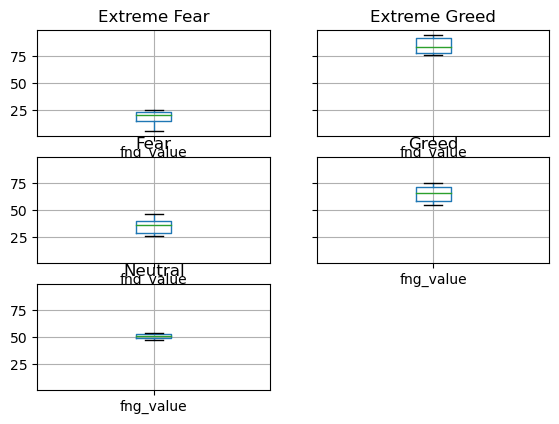

In [6]:
# Group by fng_classification and display boxplots for other columns
fng_df.groupby("fng_classification").boxplot(column=["fng_value"])

# Show the plot
plt.show()

In [7]:
merged_df = pd.merge(fng_df, trading_df, how='inner', left_index=True, right_index=True)

In [8]:
merged_df.loc[merged_df['fng_classification']=='Neutral'] = 'Greed'
merged_df.loc[merged_df['fng_classification']=='Extreme Greed'] = 'Greed'

In [9]:
merged_df

,fng_value,fng_classification,open,high,low,close,volume,actual_returns
2018-02-01 00:00:00,30,Fear,1125.96,1137.99,1120.56,1132.0,3465.84651,0.006392
2018-02-01 01:00:00,30,Fear,1132.0,1140.89,1125.01,1135.0,4149.14991,0.00265
2018-02-01 02:00:00,30,Fear,1134.07,1154.99,1134.07,1150.5,4828.74525,0.013656
2018-02-01 03:00:00,30,Fear,1150.51,1164.99,1125.01,1140.0,7622.3184,-0.009126
2018-02-01 04:00:00,30,Fear,1140.0,1154.72,1130.18,1152.51,3899.48396,0.010974
...,...,...,...,...,...,...,...,...
2023-03-05 20:00:00,Greed,Greed,Greed,Greed,Greed,Greed,Greed,Greed
2023-03-05 21:00:00,Greed,Greed,Greed,Greed,Greed,Greed,Greed,Greed
2023-03-05 22:00:00,Greed,Greed,Greed,Greed,Greed,Greed,Greed,Greed
2023-03-05 23:00:00,Greed,Greed,Greed,Greed,Greed,Greed,Greed,Greed


In [12]:
merged_df.dtypes

fng_value             object
fng_classification    object
open                  object
high                  object
low                   object
close                 object
volume                object
actual_returns        object
dtype: object

In [14]:
merged_df['fng_value'] = pd.to_numeric(merged_df['fng_value'], errors='coerce')
merged_df['open'] = pd.to_numeric(merged_df['open'], errors='coerce')
merged_df['high'] = pd.to_numeric(merged_df['high'], errors='coerce')
merged_df['low'] = pd.to_numeric(merged_df['low'], errors='coerce')
merged_df['close'] = pd.to_numeric(merged_df['close'], errors='coerce')
merged_df['volume'] = pd.to_numeric(merged_df['volume'], errors='coerce')
merged_df['actual_returns'] = pd.to_numeric(merged_df['actual_returns'], errors='coerce')


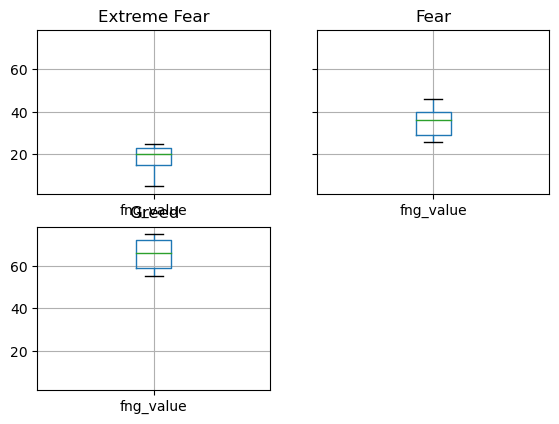

In [15]:
# Group by fng_classification and display boxplots for other columns
merged_df.groupby("fng_classification").boxplot(column=["fng_value"])

# Show the plot
plt.show()

---
## 2. Feature Engineering

In [16]:
import finta as ft
from finta import TA
import talib

ohlcv_df = merged_df

# List of time periods to use for Moving Averages calculation
timeperiods = [5,7,14,20,30,50,70,100,150,200]

df_eng = ohlcv_df.copy()

# Calculate SMAs and add them to the DataFrame
for t in timeperiods:
    #tsma = TA.SMA(df_eng t).shift(1)
    sma = TA.SMA(df_eng,t)
    ema = TA.EMA(df_eng,t)
    atr = TA.ATR(df_eng,t)  #Average True Range
    adx = TA.ADX(df_eng,t) 
    rsi = TA.RSI(df_eng,t)
    hma = TA.HMA(df_eng,t)
    vama = TA.VAMA(df_eng,t)
 
    # calculate the Force Index
    force_index = pd.Series(df_eng['close'].diff(1) * df_eng['volume'], index=df_eng.index)
    force_ema = force_index.ewm(span=t, min_periods=0, adjust=True, ignore_na=False).mean()    
    
    #df['force_index'] = force_index
    #df[f'force_index_ema_{t}'] = force_ema # add the Force Index and its EMA to the DataFrame
    #df[f'TSMA_{t}'] = tsma
    df_eng[f'SMA_{t}'] = sma
    df_eng[f'EMA_{t}'] = ema
    df_eng[f'HMA_{t}'] = hma
    df_eng[f'VAMA_{t}'] = vama
    df_eng[f'ATR_{t}'] = atr
    df_eng[f'ADX_{t}'] = adx
    df_eng[f'RSI_{t}'] = rsi
    
    
# Calculate the Parabolic SAR
#sar = TA.PSAR(df)

# Add the SAR values and trend direction to the DataFrame
#df['sar'] = sar['psar']
#df['psarbear'] = sar['psarbear']
#df['psarbull'] = sar['psarbull']

df_eng['UO'] = TA.UO(df_eng)

# Adding Awesome Indicator (AO)
df_eng['AO'] = TA.AO(df_eng)
df_eng['OBV'] =TA.OBV(df_eng)

# Adding Chaikin Indicator 
df_eng['CHAIKIN'] = TA.CHAIKIN(df_eng)

# Adding Bollinger Bands
df_eng[['BB_UPPER','BB_MED','BB_LOWER']] =TA.BBANDS(df_eng)

# Calculate the Keltner Channel with TALIB
#df[['KC_UPPER','KC_MED','KC_LOWER']] = TA.KC(df)

# calculate Commodity Channel Index (CCI)
df_eng['cci'] = TA.CCI(df_eng)

# assuming you have OHLCV data in a pandas dataframe called "df"
#volume_momentum = talib.MOM(df['volume'])

ValueError: cannot reindex on an axis with duplicate labels

In [9]:
# calculate the Ichimoku Kinko Hyo indicator
# Calculate the conversion line
nine_period_high = df_eng['high'].rolling(window=9).max()
nine_period_low = df_eng['low'].rolling(window=9).min()
df_eng['tenkan_sen'] = (nine_period_high + nine_period_low) / 2

# Calculate the base line
periods = 26
twenty_six_period_high = df_eng['high'].rolling(window=periods).max()
twenty_six_period_low = df_eng['low'].rolling(window=periods).min()
df_eng['kijun_sen'] = (twenty_six_period_high + twenty_six_period_low) / 2

# Calculate the leading span A
df_eng['senkou_span_a'] = ((df_eng['tenkan_sen'] + df_eng['kijun_sen']) / 2).shift(periods=periods)

# Calculate the leading span B
periods2 = 52
fifty_two_period_high = df_eng['high'].rolling(window=periods2).max()
fifty_two_period_low = df_eng['low'].rolling(window=periods2).min()
df_eng['senkou_span_b'] = ((fifty_two_period_high + fifty_two_period_low) / 2).shift(periods=periods)

# Calculate the lagging span
df_eng['chikou_span'] = df_eng['close'].shift(periods=-periods)


#### Add a daily return values column to the DataFrame

In [17]:
# Calculate the daily returns using the closing prices and the pct_change function
df_eng["actual_returns"] = df_eng["close"].pct_change()

# Drop all NaN values from the DataFrame
df_eng = df_eng.dropna()

# Review the DataFrame
df_eng.head()

,fng_value,fng_classification,open,high,low,close,volume,actual_returns,SMA_5,EMA_5,...,RSI_150,SMA_200,EMA_200,HMA_200,VAMA_200,ATR_200,ADX_200,RSI_200,UO,AO
2018-03-19 14:00:00,29.0,Fear,545.96,557.00,542.00,547.05,13778.23787,0.001996,537.384,540.594697,...,45.084131,624.39750,611.047911,509.846175,603.788909,13.17715,26.701401,45.102035,52.386260,16.061618
2018-03-19 15:00:00,29.0,Fear,547.78,555.00,541.18,550.30,6502.91226,0.005941,541.900,543.829798,...,45.256970,623.70655,610.440777,509.534317,603.079405,13.18855,26.663928,45.236621,54.721230,20.276794
2018-03-19 16:00:00,29.0,Fear,550.40,560.00,540.00,540.40,10411.78174,-0.017990,542.360,542.686532,...,44.824342,622.94450,609.740798,509.247071,602.317263,13.24190,26.622728,44.899633,53.759764,22.823735
2018-03-19 17:00:00,29.0,Fear,540.02,541.02,527.19,532.20,13331.67254,-0.015174,543.182,539.191021,...,44.469873,622.18675,608.965898,508.950057,601.214951,13.25330,26.588513,44.622914,50.492399,23.098029
2018-03-19 18:00:00,29.0,Fear,532.20,541.12,530.31,532.59,5594.22643,0.000733,540.508,536.990681,...,44.490891,621.41145,608.202673,508.644997,600.609854,13.25710,26.554402,44.639223,45.460706,22.121412


---
## 3. Pre-Processing
### 3.1 Remove highly-correlated features

In [18]:
df_feats = df_eng.copy()
df_feats = df_feats.drop(["open","high","low","fng_value"], axis =1)

In [19]:

# Calculate correlation matrix
# calculate the correlation matrix of the features
corr_matrix = df_feats.corr()

# set the threshold for correlation value
corr_threshold = 0.45

# find the highly correlated features and drop them from the dataframe
high_corr_features = np.where(corr_matrix.abs() > corr_threshold)
high_corr_features = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]
df_feats.drop([col[1] for col in high_corr_features], axis=1, inplace=True)

# select the remaining features with low correlation
low_corr_features = df_feats.columns.tolist()

# print the low correlated features
print(low_corr_features)

ValueError: could not convert string to float: 'Fear'

In [20]:
df_feats = df_feats[['fng_classification', 'volume', 'ADX_5']]

In [21]:
# replace spaces with underscores in the categorical column
df_feats["fng_classification"] = df_feats["fng_classification"].str.replace("Extreme ", "Hi_")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
df_feats["fng_classification"].value_counts()

fng_classification
Hi_Fear    10420
Fear        8329
Greed        250
Name: count, dtype: int64

In [23]:
# Get dummy variables for the categorical column
dummy_df = pd.get_dummies(df_feats['fng_classification'], prefix='fng')

# Concatenate the original DataFrame with the dummy-encoded DataFrame
df_encoded = pd.concat([df_feats, dummy_df], axis=1)

# Drop the original categorical column (optional)
df_encoded.drop('fng_classification', axis=1, inplace=True)

df_encoded

,volume,ADX_5,fng_Fear,fng_Greed,fng_Hi_Fear
2018-03-19 14:00:00,13778.23787,26.893527,True,False,False
2018-03-19 15:00:00,6502.91226,25.420921,True,False,False
2018-03-19 16:00:00,10411.78174,26.342661,True,False,False
2018-03-19 17:00:00,13331.67254,22.798825,True,False,False
2018-03-19 18:00:00,5594.22643,19.887735,True,False,False
...,...,...,...,...,...
2023-01-14 19:00:00,16207.93580,17.602837,True,False,False
2023-01-14 20:00:00,9248.96400,16.378613,True,False,False
2023-01-14 21:00:00,15097.22710,20.203488,True,False,False
2023-01-14 22:00:00,17498.84950,30.471088,True,False,False


---
### 4 Clustering

> values that works well: dbscan = DBSCAN(eps=3, min_samples=600)

In [24]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(df_encoded)

# Create and fit the DBSCAN model
dbscan = DBSCAN(eps=3, min_samples=200)
clusters = dbscan.fit_predict(X)

# Add the cluster labels to the original dataframe
df_encoded['cluster'] = clusters

In [25]:
unique_clusters = df_encoded['cluster'].unique()
print(unique_clusters)

[ 0  1 -1]


In [26]:
df_encoded[['close','actual_returns']] = df_eng[['close','actual_returns']]

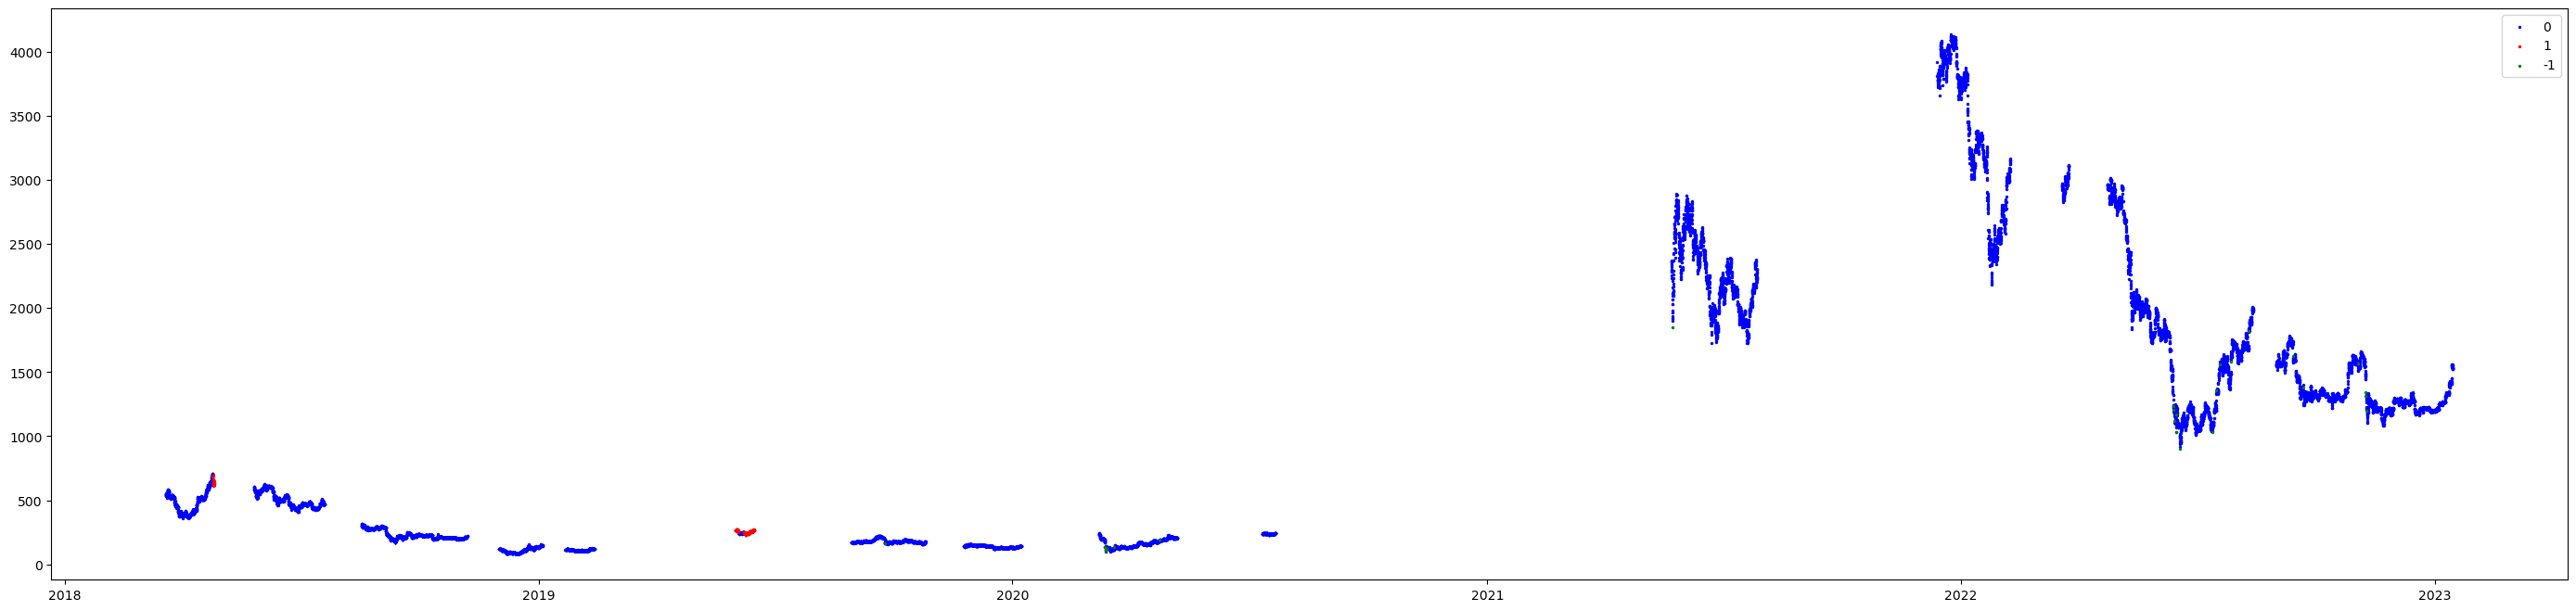

In [28]:
# Plot the time series with clusters in different colors
fig, ax = plt.subplots(figsize=(35, 8))
for label, color in zip(df_encoded['cluster'].unique(), ['blue', 'red', 'green']):
    mask = df_encoded['cluster'] == label
    ax.scatter(df_encoded.index[mask], df_encoded['close'][mask], label=label, c=color, s=2)
ax.legend()
plt.show()

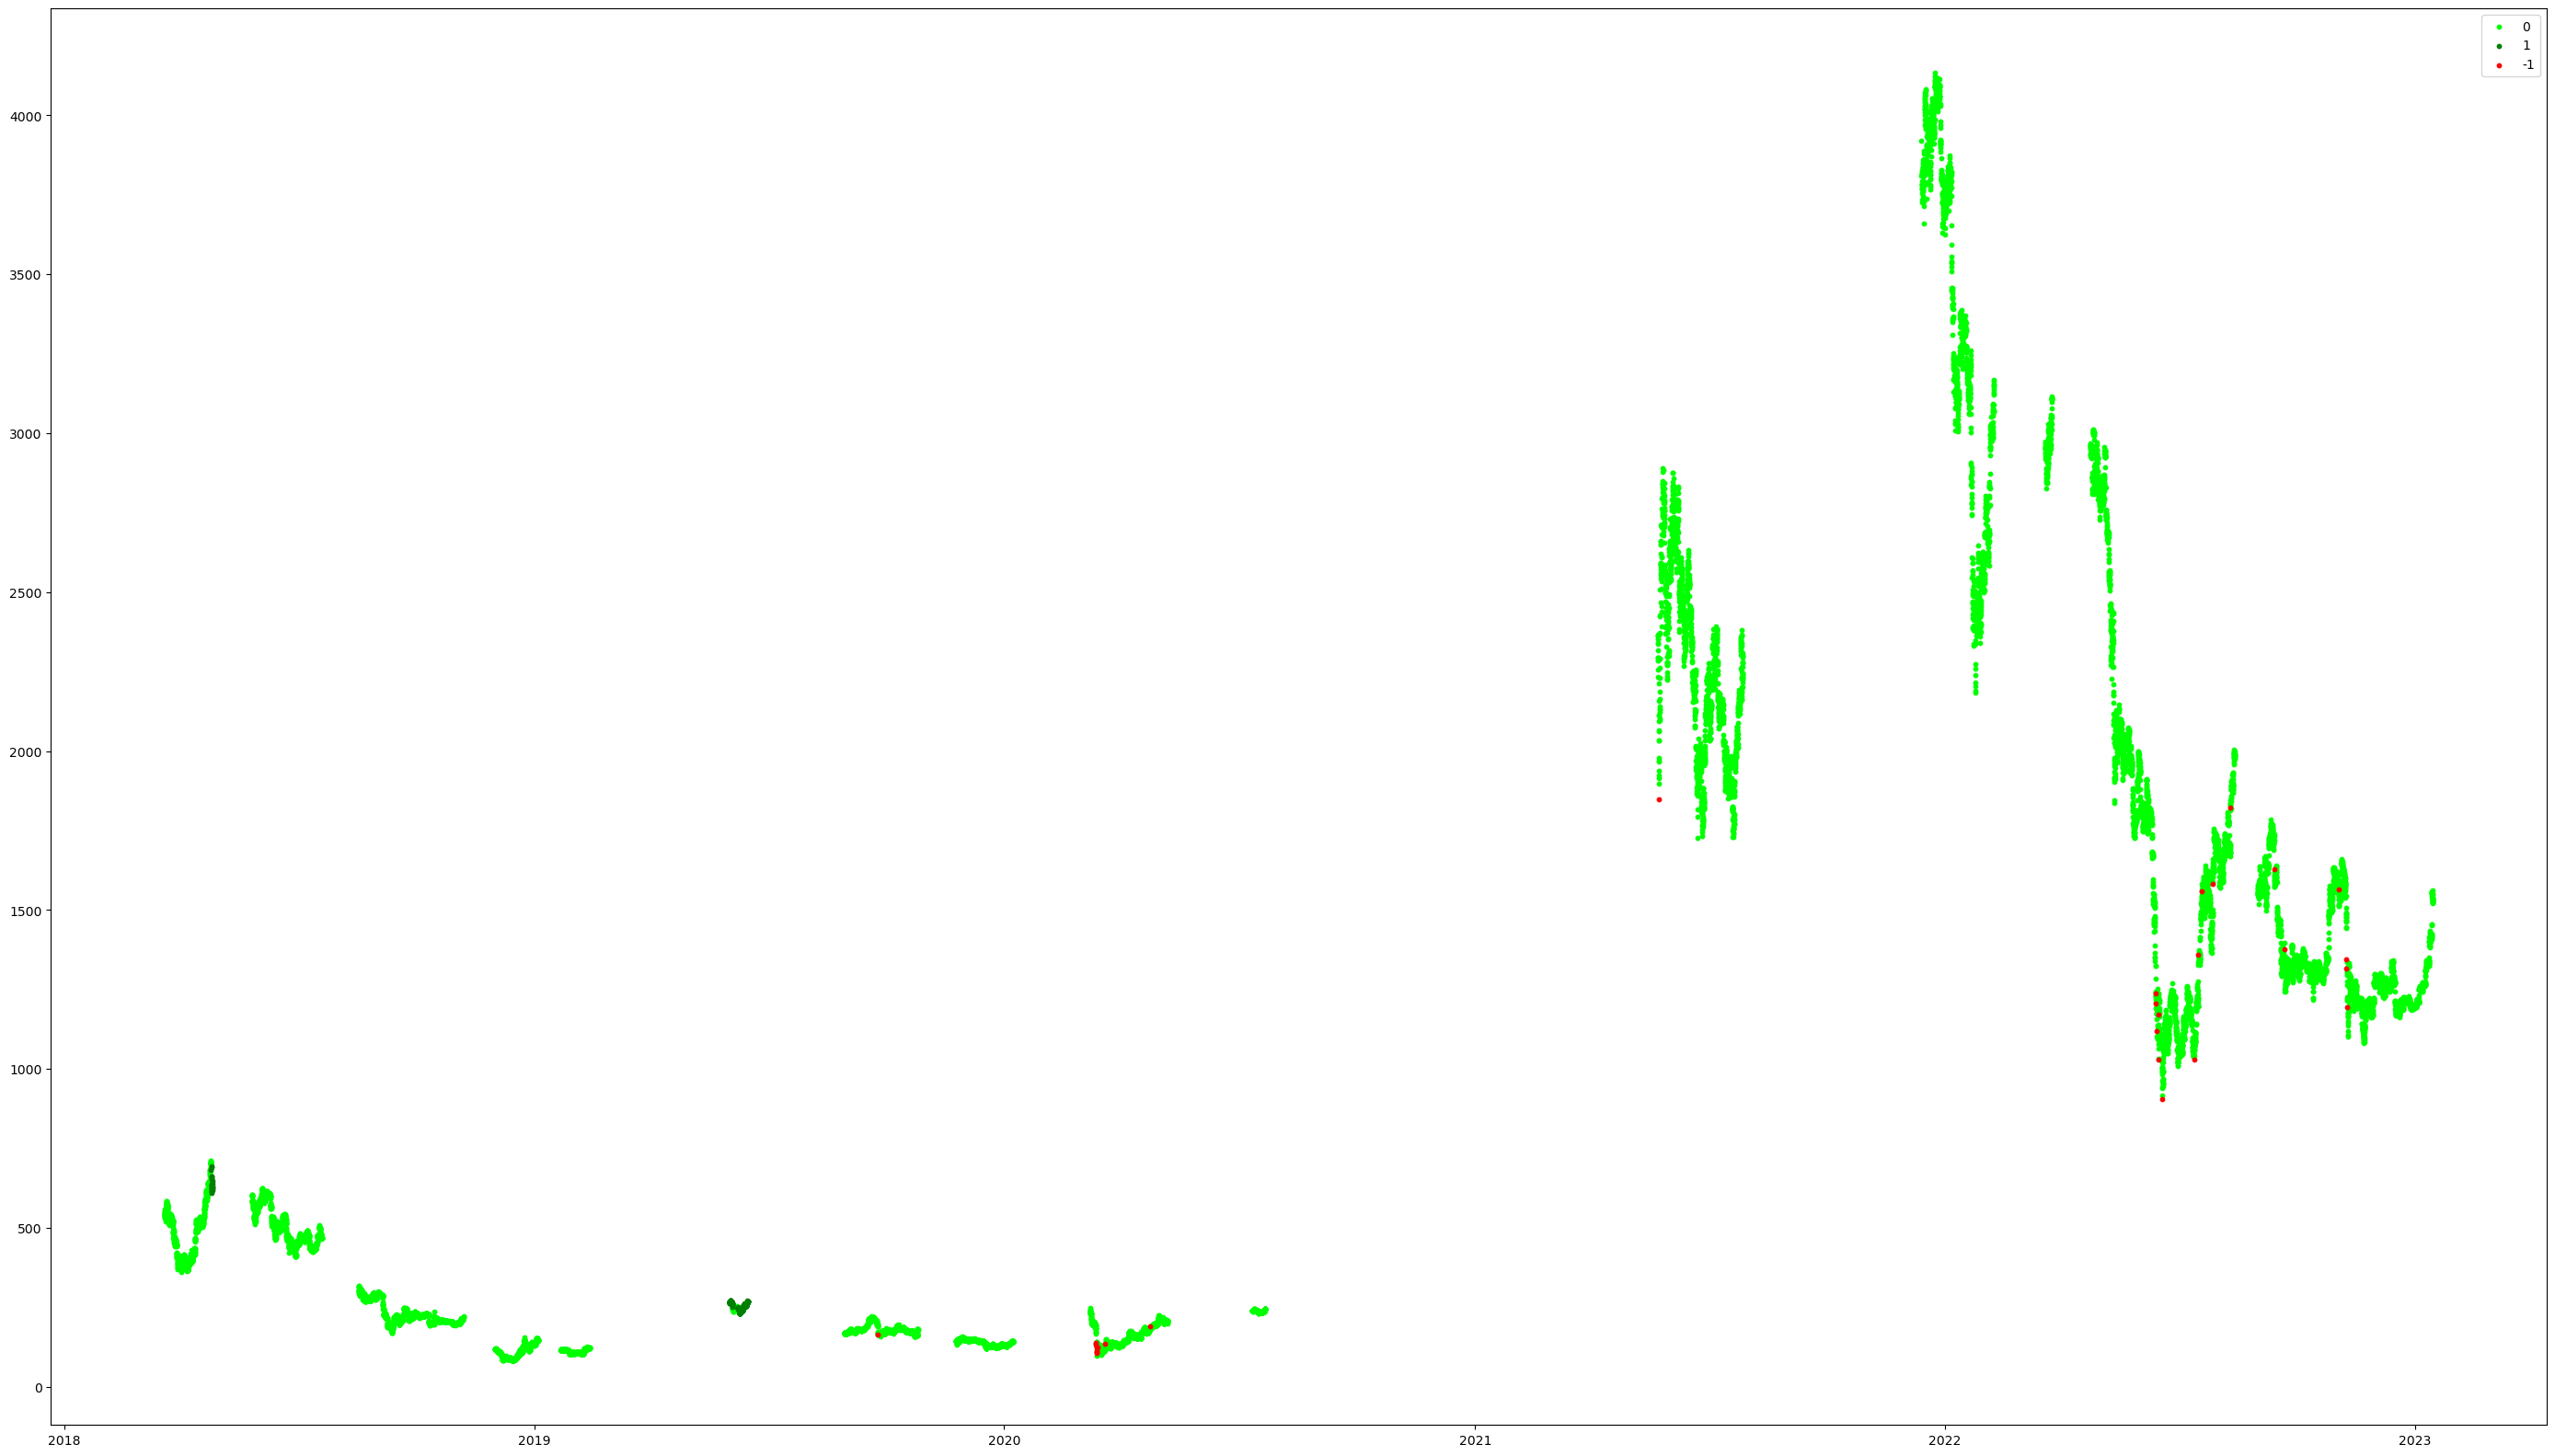

In [29]:
# Plot the time series with clusters in different colors
fig, ax = plt.subplots(figsize=(35, 20))
for label, color in zip(df_encoded['cluster'].unique(), ['lime', 'green', 'red', 'red', 'lime','green','black','black','red','magenta']):
    mask = df_encoded['cluster'] == label
    ax.scatter(df_encoded.index[mask], df_encoded['close'][mask], label=label, c=color, s=10)
ax.legend()
plt.show()

In [31]:
# Display the plot inline in Jupyter Lab
%matplotlib inline

# Create the scatter plot using hvplot.scatter
scatter = df_encoded.hvplot.scatter(x='index', y='close', by='cluster', legend='top')

# Set the plot options
scatter.opts(
    title='Time Series with Clusters',
    xlabel='Date',
    ylabel='Close Price',
    height=500,
    width=1000
)

# Show the plot
hvplot.show(scatter)

Launching server at http://localhost:62012


In [32]:
df_eda  = df_encoded


In [33]:
df_eda [['fng_value','fng_classification','actual_returns']] = df_eng [['fng_value','fng_classification','actual_returns']]

In [34]:
df_eda.columns

Index(['volume', 'ADX_5', 'fng_Fear', 'fng_Greed', 'fng_Hi_Fear', 'cluster',
       'close', 'actual_returns', 'fng_value', 'fng_classification'],
      dtype='object')

<Axes: xlabel='cluster', ylabel='fng_value'>

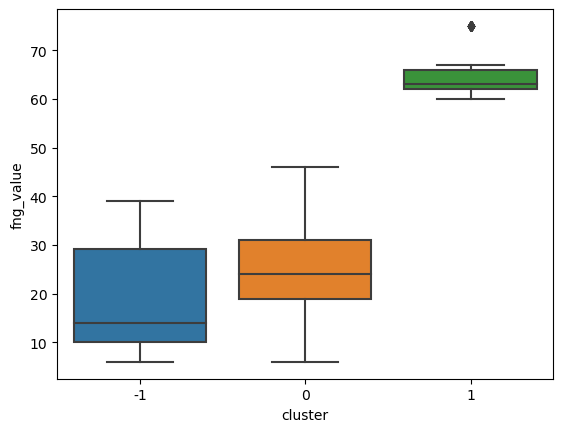

In [37]:
import seaborn as sns

# create a new DataFrame with just the relevant columns
cluster_df = df_eda[['cluster', 'fng_value', 'actual_returns']]

# create boxplots of fng_value and actual_returns for each cluster
sns.boxplot(data=cluster_df, x='cluster', y='fng_value')


In [45]:
df_eda['signal'].unique()

array([1, 0])

In [46]:
df_eda['signal'].value_counts()

signal
1    18721
0      278
Name: count, dtype: int64

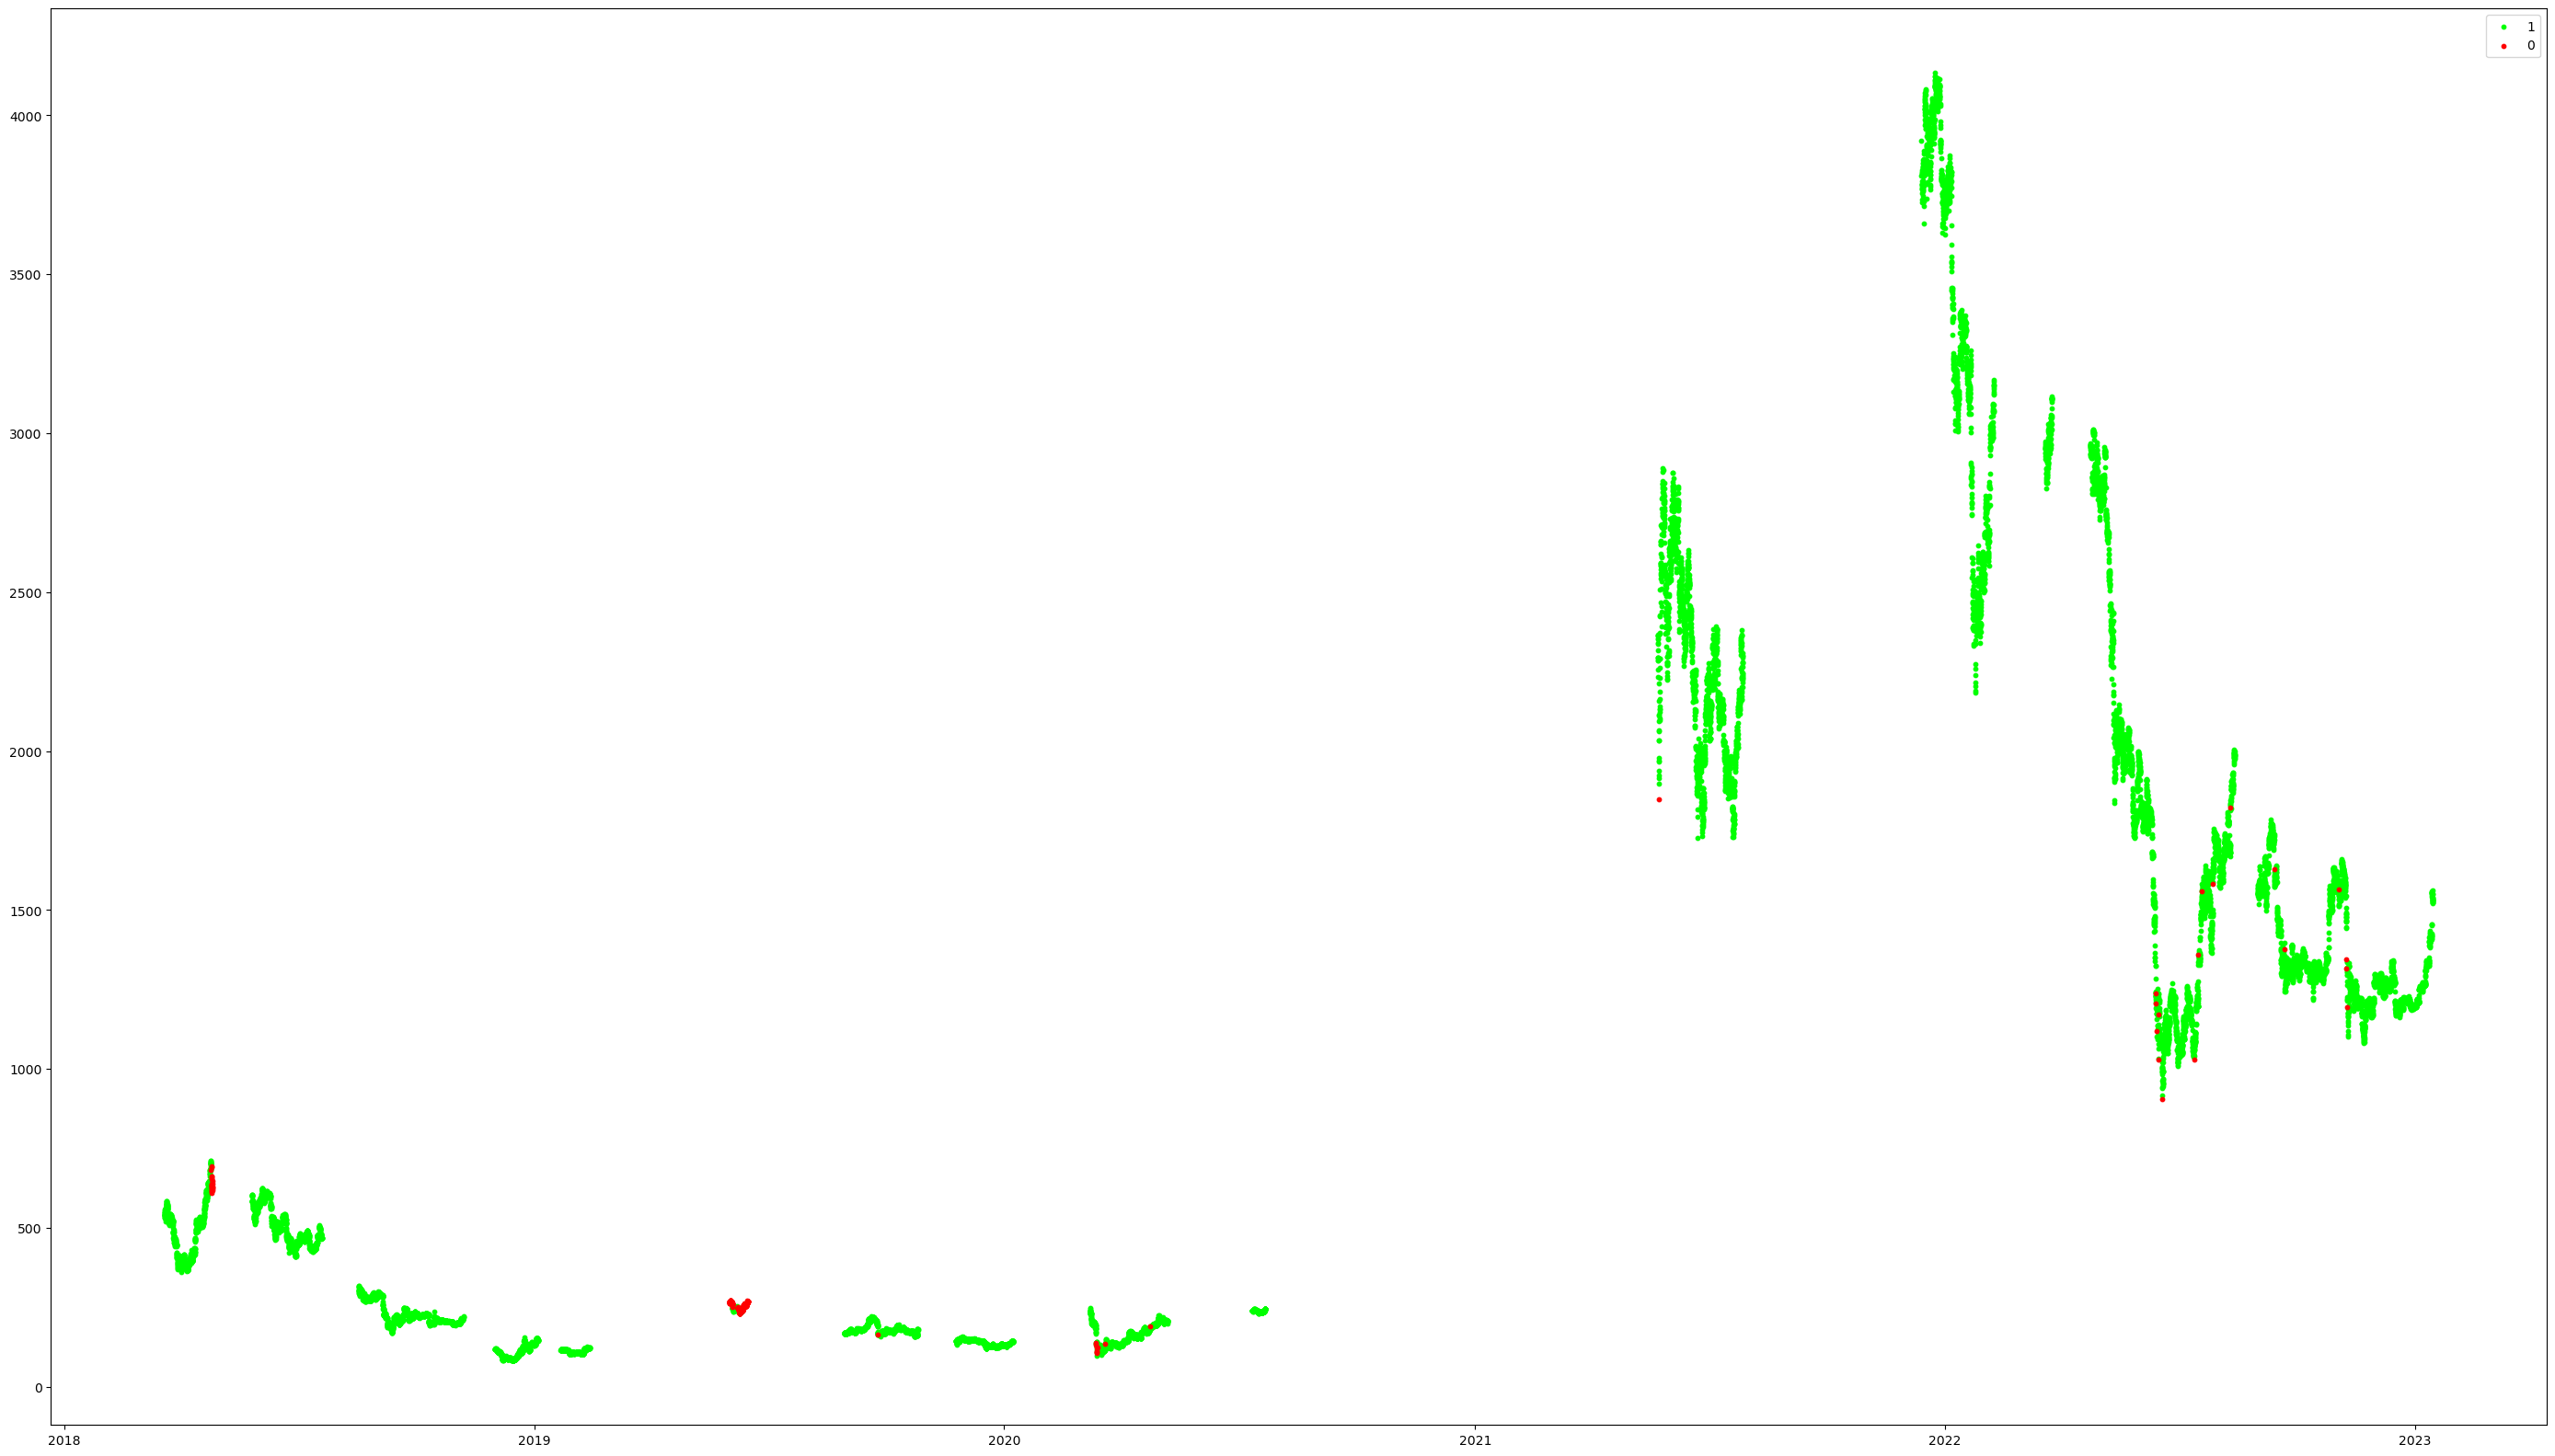

In [47]:
# Plot the time series with clusters in different colors
fig, ax = plt.subplots(figsize=(35, 20))
for label, color in zip(df_eda['signal'].unique(), ['lime','red']):
    mask = df_eda['signal'] == label
    ax.scatter(df_eda.index[mask], df_eda['close'][mask], label=label, c=color, s=10)
ax.legend()
plt.show()

In [39]:
# Display the plot inline in Jupyter Lab
%matplotlib inline

# Plot the time series with clusters in different colors
plot = df_encoded.hvplot.scatter(x='index', y='close',  c='cluster', legend='top_left', height=500, width=1000, title='Clusters of Time Series')

# Show the plot in Jupyter notebook
plot

:Scatter   [index]   (close,cluster)

In [40]:
# Set initial capital
initial_capital = float(100000)

# Set the share size
share_size = 500

# Buy a 500 share position when the dual moving average crossover Signal equals 1
# Otherwise, `Position` should be zero (sell)
df_eda['Position'] = share_size * df_eda['signal']

# Determine the points in time where a 500 share position is bought or sold
df_eda['Entry/Exit Position'] = df_eda['Position'].diff()

# Multiply the close price by the number of shares held, or the Position
df_eda['Portfolio Holdings'] = df_eda['close'] * df_eda['Position']

# Subtract the amount of either the cost or proceeds of the trade from the initial capital invested
df_eda['Portfolio Cash'] = initial_capital - (df_eda['close'] * df_eda['Entry/Exit Position']).cumsum() 

# Calculate the total portfolio value by adding the portfolio cash to the portfolio holdings (or investments)
df_eda['Portfolio Total'] = df_eda['Portfolio Cash'] + df_eda['Portfolio Holdings']

# Calculate the portfolio daily returns
df_eda['Portfolio Daily Returns'] = df_eda['Portfolio Total'].pct_change()

# Calculate the portfolio cumulative returns
df_eda['Portfolio Cumulative Returns'] = (1 + df_eda['Portfolio Daily Returns']).cumprod() - 1



In [44]:
# Visualize the value of the total portfolio
total_portfolio_value = df_eda[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    xlabel='Date',
    width=1000,
    height=400
)


In [42]:
total_portfolio_value

:Curve   [index]   (Portfolio Total)

In [43]:
df_eda.head()

,volume,ADX_5,fng_Fear,fng_Greed,fng_Hi_Fear,cluster,close,actual_returns,fng_value,fng_classification,signal,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
2018-03-19 14:00:00,13778.23787,26.893527,True,False,False,0,547.05,0.001996,29.0,Fear,1,500,NaN,273525.0,NaN,NaN,NaN,NaN
2018-03-19 15:00:00,6502.91226,25.420921,True,False,False,0,550.30,0.005941,29.0,Fear,1,500,0.0,275150.0,100000.0,375150.0,NaN,NaN
2018-03-19 16:00:00,10411.78174,26.342661,True,False,False,0,540.40,-0.017990,29.0,Fear,1,500,0.0,270200.0,100000.0,370200.0,-0.013195,-0.013195
2018-03-19 17:00:00,13331.67254,22.798825,True,False,False,0,532.20,-0.015174,29.0,Fear,1,500,0.0,266100.0,100000.0,366100.0,-0.011075,-0.024124
2018-03-19 18:00:00,5594.22643,19.887735,True,False,False,0,532.59,0.000733,29.0,Fear,1,500,0.0,266295.0,100000.0,366295.0,0.000533,-0.023604


In [38]:
df_eda.to_csv('DBSCANed_labels_2.7x.csv')

---
## 2ND Feat Engineering

In [39]:
import finta as ft
from finta import TA
import talib

prep_df = df_eng.copy()
prep_df['signal'] = df_eda['signal']


In [40]:
prep_df.columns

Index(['fng_value', 'fng_classification', 'open', 'high', 'low', 'close',
       'volume', 'actual_returns', 'SMA_5', 'EMA_5', 'HMA_5', 'VAMA_5',
       'ATR_5', 'ADX_5', 'RSI_5', 'SMA_7', 'EMA_7', 'HMA_7', 'VAMA_7', 'ATR_7',
       'ADX_7', 'RSI_7', 'SMA_14', 'EMA_14', 'HMA_14', 'VAMA_14', 'ATR_14',
       'ADX_14', 'RSI_14', 'SMA_20', 'EMA_20', 'HMA_20', 'VAMA_20', 'ATR_20',
       'ADX_20', 'RSI_20', 'SMA_30', 'EMA_30', 'HMA_30', 'VAMA_30', 'ATR_30',
       'ADX_30', 'RSI_30', 'SMA_50', 'EMA_50', 'HMA_50', 'VAMA_50', 'ATR_50',
       'ADX_50', 'RSI_50', 'SMA_70', 'EMA_70', 'HMA_70', 'VAMA_70', 'ATR_70',
       'ADX_70', 'RSI_70', 'SMA_100', 'EMA_100', 'HMA_100', 'VAMA_100',
       'ATR_100', 'ADX_100', 'RSI_100', 'SMA_150', 'EMA_150', 'HMA_150',
       'VAMA_150', 'ATR_150', 'ADX_150', 'RSI_150', 'SMA_200', 'EMA_200',
       'HMA_200', 'VAMA_200', 'ATR_200', 'ADX_200', 'RSI_200', 'UO', 'AO',
       'OBV', 'CHAIKIN', 'BB_UPPER', 'BB_MED', 'BB_LOWER', 'cci', 'tenkan_sen',
       'kiju

In [41]:
# Dummy-encoding process 
# create a list of categorical columns
cat_cols = ['fng_classification']

# use the get_dummies function to dummy encode the categorical columns
dummy_cols = pd.get_dummies(prep_df[cat_cols], prefix=cat_cols, drop_first=True)

# concatenate the dummy columns with the original dataframe
prep_df = pd.concat([prep_df.drop(cat_cols, axis=1), dummy_cols], axis=1)

In [42]:
prep_df['signal'].value_counts()

0    31382
1    11602
Name: signal, dtype: int64

___
### 3.5 Class Imbalance

In [43]:
import pandas as pd
from sklearn.utils import resample

# Count the number of samples in each class
class_counts = prep_df['signal'].value_counts()

# Find the class with fewer samples
minority_class = class_counts.idxmin()

# Split the dataframe into the majority and minority classes
majority_class = prep_df[prep_df['signal'] != minority_class]
minority_class = prep_df[prep_df['signal'] == minority_class]

# Undersample the majority class to match the number of samples in the minority class
undersampled_majority = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

# Combine the undersampled majority class with the minority class
balanced_df = pd.concat([undersampled_majority, minority_class])

# Shuffle the rows in the balanced dataframe
balanced_df = balanced_df.sample(frac=1, random_state=42)

In [44]:
balanced_df["signal"].value_counts()

0    11602
1    11602
Name: signal, dtype: int64

In [45]:
# Creating X as predictors (features) dataset
X= balanced_df.copy()

# sort X by index
X = X.sort_index(axis=0)

# Removing columns indicative of previous prices
# & shifting X one row down to avoid using data not available to us at the time of prediction
X= X.drop(["open","high","low","close","volume","actual_returns","signal",
           "fng_classification_Fear","fng_classification_Extreme Greed",
           "fng_classification_Greed","fng_classification_Neutral",
           "fng_value"
          ], axis =1).shift().dropna().copy()

In [46]:
# Copy the new signal column to a new Series called y.
y = balanced_df["signal"].copy()

# keeping y and X the same size 
y = y[X.index]

In [47]:
from sklearn.preprocessing import StandardScaler

# Scale the data
MLscaler = StandardScaler()
X_scaled = MLscaler.fit_transform(X)

In [48]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Scale the data
X_scaled = scaler.fit_transform(X)

# Convert X_scaled back to a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Create a logistic regression model
model = LogisticRegression(max_iter=900)

# Create an RFE model to select the best features
rfe = RFE(model, n_features_to_select=25)

# Fit the RFE model to the data
rfe = rfe.fit(X_scaled, y)

# Get the selected features
selected_features = X_scaled.columns[rfe.support_]

# Keep only specified columns in the dataframe
X_scaled = X_scaled[selected_features]

# Print the selected features
print("Number of selected features:", len(X_scaled.columns), "\nSelected features:\n", selected_features)


Number of selected features: 25 
Selected features:
 Index(['HMA_5', 'SMA_30', 'RSI_30', 'RSI_50', 'RSI_70', 'SMA_100', 'VAMA_100',
       'ATR_100', 'ADX_100', 'RSI_100', 'SMA_150', 'EMA_150', 'VAMA_150',
       'ATR_150', 'RSI_150', 'SMA_200', 'EMA_200', 'HMA_200', 'ADX_200',
       'RSI_200', 'OBV', 'tenkan_sen', 'kijun_sen', 'senkou_span_b',
       'chikou_span'],
      dtype='object')


In [49]:
selected_features=['HMA_5', 'SMA_30', 'RSI_30', 'RSI_50', 'RSI_70', 'SMA_100', 'VAMA_100',
       'ATR_100', 'ADX_100', 'RSI_100', 'SMA_150', 'EMA_150', 'VAMA_150',
       'ATR_150', 'RSI_150', 'SMA_200', 'EMA_200', 'HMA_200', 'ADX_200',
       'RSI_200', 'OBV', 'tenkan_sen', 'kijun_sen', 'senkou_span_b',
       'chikou_span']

In [50]:
rfe.support_

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False,  True,  True, False, False,  True,  True,
        True,  True,  True,  True, False,  True,  True, False,  True,
        True,  True,  True, False, False,  True,  True, False, False,
        True, False, False, False, False, False,  True,  True, False,
        True,  True])

In [51]:
df_lo_feats = X[selected_features].copy()
# Calculate correlation matrix
# calculate the correlation matrix of the features
corr_matrix = df_lo_feats.corr()

# set the threshold for correlation value
corr_threshold = 0.90

# find the highly correlated features and drop them from the dataframe
high_corr_features = np.where(corr_matrix.abs() > corr_threshold)
high_corr_features = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]
df_lo_feats.drop([col[1] for col in high_corr_features], axis=1, inplace=True)

# select the remaining features with low correlation
low_corr_features = df_lo_feats.columns.tolist()

# print the low correlated features
print(low_corr_features)

['HMA_5', 'RSI_30', 'ATR_100', 'ADX_100', 'ADX_200']


In [52]:
#X=X[low_corr_features]
X = X[selected_features]

In [97]:
# Imports 
from pandas.tseries.offsets import DateOffset

# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
#print(training_begin)

# Select the ending period for the training data with an offset of 36 months
training_end = X.index.min() + DateOffset(months=36)

# Display the training end date
#print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
display(X_train.head())

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
display(X_test.head())

,HMA_5,SMA_30,RSI_30,RSI_50,RSI_70,SMA_100,VAMA_100,ATR_100,ADX_100,RSI_100,...,SMA_200,EMA_200,HMA_200,ADX_200,RSI_200,OBV,tenkan_sen,kijun_sen,senkou_span_b,chikou_span
2018-02-19 00:00:00,907.645333,940.972000,43.753247,47.512581,49.261935,936.7372,934.708819,13.4564,6.797510,50.064328,...,891.60280,905.738098,967.622955,9.394577,49.654668,-182171.31971,928.27,937.75,937.68,951.59
2018-02-19 01:00:00,912.577333,939.608667,46.510099,49.099413,50.319500,936.9104,934.810413,13.5109,6.821503,50.742588,...,892.11535,905.900494,966.967699,9.390300,49.975991,-177087.87414,925.74,937.75,937.68,942.70
2018-02-19 02:00:00,926.347333,938.563667,48.274786,50.134498,51.016445,937.1472,934.975033,13.5994,6.819080,51.193153,...,892.55945,906.134585,966.294332,9.366996,50.190969,-173257.72129,925.74,937.75,937.68,945.06
2018-02-19 03:00:00,930.762222,937.415000,47.579502,49.692983,50.707447,937.2062,935.072718,13.5822,6.828418,50.991423,...,893.05135,906.334851,965.591862,9.352467,50.098320,-176770.64628,925.74,937.75,937.68,946.53
2018-02-19 04:00:00,925.075333,935.980333,46.578813,49.057313,50.262117,937.2296,935.168387,13.6011,6.837653,50.700431,...,893.45515,906.487769,964.845680,9.338092,49.964661,-179431.94350,925.74,937.75,939.68,947.93


,HMA_5,SMA_30,RSI_30,RSI_50,RSI_70,SMA_100,VAMA_100,ATR_100,ADX_100,RSI_100,...,SMA_200,EMA_200,HMA_200,ADX_200,RSI_200,OBV,tenkan_sen,kijun_sen,senkou_span_b,chikou_span
2021-02-19 00:00:00,1940.672444,1896.731333,62.697622,59.476882,57.656003,1819.1980,1818.047204,25.5812,6.933268,56.248241,...,1806.35000,1799.287875,1851.447284,4.121721,54.743261,3.606997e+06,1924.90,1890.300,1788.890,1950.43
2021-02-19 01:00:00,1931.795778,1900.418000,60.426273,58.230615,56.814413,1820.3082,1819.177019,25.6351,6.928360,55.691595,...,1807.42025,1800.572771,1854.766021,4.122795,54.491247,3.569365e+06,1929.22,1891.590,1789.500,1983.35
2021-02-19 02:00:00,1917.562000,1903.056667,58.185297,56.978581,55.962742,1821.2068,1820.213561,25.7789,6.904817,55.125285,...,1808.36970,1801.730455,1858.021763,4.118845,54.233375,3.527965e+06,1930.00,1900.845,1789.500,2018.93
2021-02-19 03:00:00,1910.624000,1905.958333,58.107756,56.935132,55.933156,1822.1338,1821.405634,25.9806,6.864258,55.105598,...,1809.26715,1802.872640,1861.209343,4.110189,54.224405,3.480045e+06,1921.50,1908.820,1796.825,2022.20
2021-02-19 04:00:00,1907.932667,1907.865667,56.870952,56.244742,55.463885,1823.2317,1822.149085,25.8806,6.828624,54.793779,...,1810.10950,1803.940673,1864.300607,4.102828,54.082581,3.456594e+06,1921.50,1915.620,1821.610,2014.45


In [98]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---
## 4. ML models 
#### 4.1 XGboost

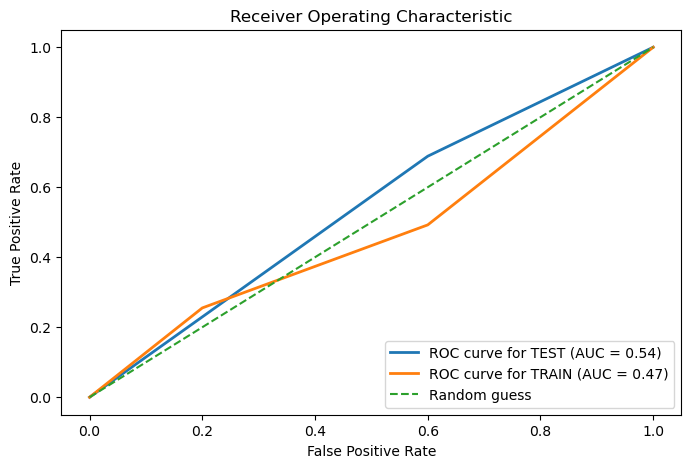

TRAINING classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      6747
           1       0.54      1.00      0.70      7891

    accuracy                           0.54     14638
   macro avg       0.27      0.50      0.35     14638
weighted avg       0.29      0.54      0.38     14638


TESTING classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      4855
           1       0.43      1.00      0.60      3711

    accuracy                           0.43      8566
   macro avg       0.22      0.50      0.30      8566
weighted avg       0.19      0.43      0.26      8566

Test accuracy: 0.43
>> Test precision: 0.43 <<
Test recall: 0.43
Test F1 score: 0.43
Test AUC score: 0.54


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [99]:
import xgboost as xgb
#from xgboost import xgbClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

#replace -1 by 0 as xgboost expects a boolean target vector (only 0 and 1)
y_train = y_train.replace(-1, 0)
y_test = y_test.replace(-1, 0)

# Create a xgb Classifier model
xgb_clf = xgb.XGBClassifier(reg_alpha=0)

xgb_clf.fit(X_train_scaled, y_train) 

# Use the best model to make predictions on the test data
y_pred_xgb = xgb_clf.predict(X_test_scaled)

ROC(xgb_clf,X_train,X_test,y_train,y_test)

<Axes: >

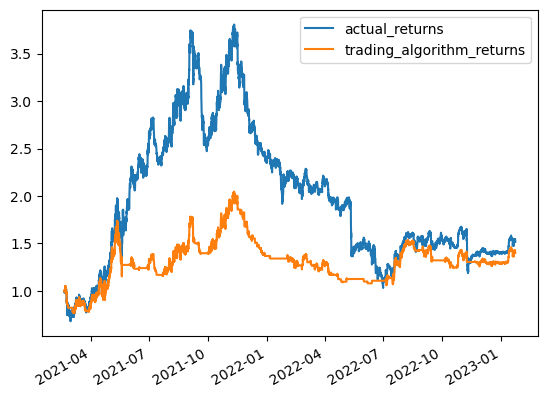

In [100]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = xgb_clf

# Backtest using our exteranl function
xgb_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + xgb_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

> The XGB results appear to be too good to be true - the classification report are very weird as well --> not to use for production

In [101]:
X_test.columns


Index(['HMA_5', 'SMA_30', 'RSI_30', 'RSI_50', 'RSI_70', 'SMA_100', 'VAMA_100',
       'ATR_100', 'ADX_100', 'RSI_100', 'SMA_150', 'EMA_150', 'VAMA_150',
       'ATR_150', 'RSI_150', 'SMA_200', 'EMA_200', 'HMA_200', 'ADX_200',
       'RSI_200', 'OBV', 'tenkan_sen', 'kijun_sen', 'senkou_span_b',
       'chikou_span'],
      dtype='object')

---
#### 4.2 CatBoost

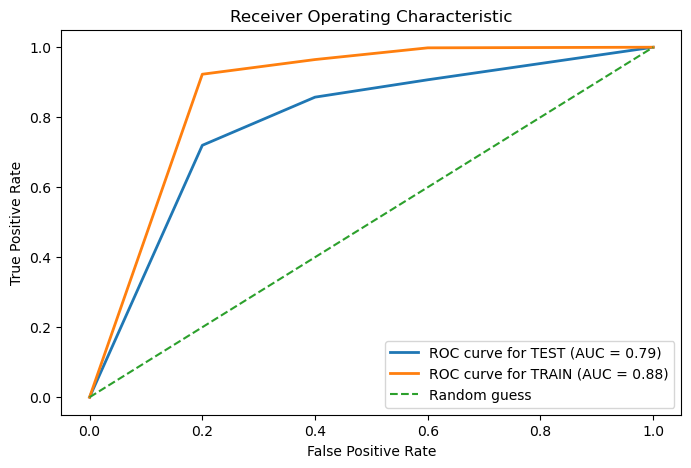

TRAINING classification report: 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      6747
           1       0.90      0.85      0.87      7891

    accuracy                           0.87     14638
   macro avg       0.87      0.87      0.87     14638
weighted avg       0.87      0.87      0.87     14638


TESTING classification report: 
               precision    recall  f1-score   support

           0       0.84      0.59      0.69      4855
           1       0.61      0.86      0.72      3711

    accuracy                           0.70      8566
   macro avg       0.73      0.72      0.70      8566
weighted avg       0.74      0.70      0.70      8566

Test accuracy: 0.70
>> Test precision: 0.70 <<
Test recall: 0.70
Test F1 score: 0.70
Test AUC score: 0.79


In [102]:
# Import libraries
from catboost import CatBoostClassifier
# Initialize the CatBoost model

cb_clf = CatBoostClassifier(iterations=770,random_state=seed,l2_leaf_reg=9500000000, verbose = False)

# Train the model on the training data
cb_clf.fit(X_train_scaled, y_train)

# display ROC and classification metrics 
ROC(cb_clf,X_train_scaled, X_test_scaled, y_train, y_test)


<Axes: >

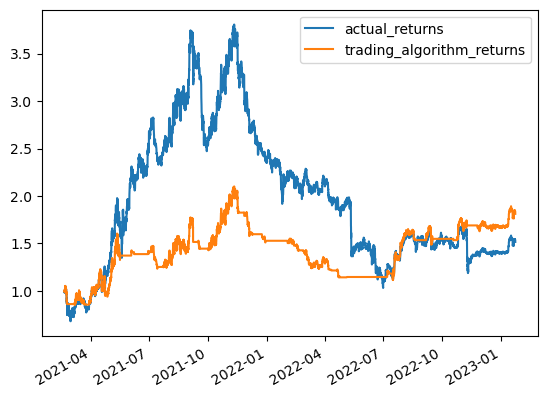

In [103]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = cb_clf

# Backtest using our exteranl function
cb_predictions_df = Backtesting (df_eda, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + cb_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

---
#### 4.3 LDA

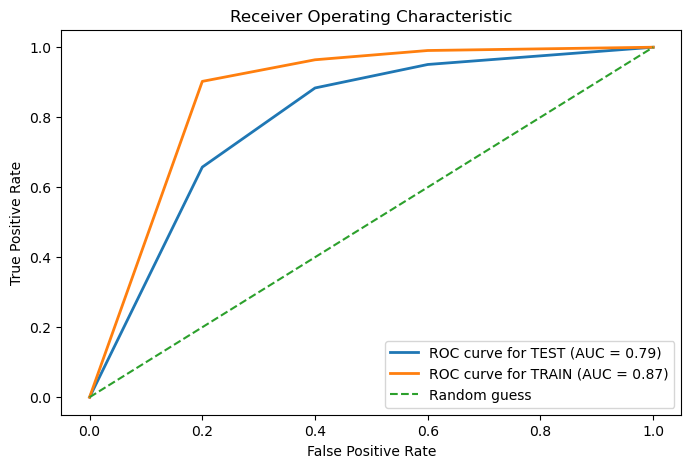

TRAINING classification report: 
               precision    recall  f1-score   support

           0       0.87      0.82      0.85      6747
           1       0.85      0.90      0.88      7891

    accuracy                           0.86     14638
   macro avg       0.86      0.86      0.86     14638
weighted avg       0.86      0.86      0.86     14638


TESTING classification report: 
               precision    recall  f1-score   support

           0       0.93      0.35      0.51      4855
           1       0.53      0.97      0.69      3711

    accuracy                           0.62      8566
   macro avg       0.73      0.66      0.60      8566
weighted avg       0.76      0.62      0.59      8566

Test accuracy: 0.62
>> Test precision: 0.62 <<
Test recall: 0.62
Test F1 score: 0.62
Test AUC score: 0.79


In [104]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# create LDA object and fit the model
lda = LinearDiscriminantAnalysis()

# Train the model on the training data
lda.fit_transform(X_train_scaled, y_train)

ROC(lda,X_train_scaled, X_test_scaled, y_train, y_test)

<Axes: >

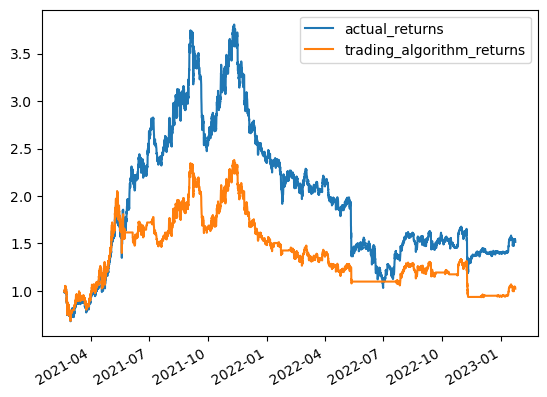

In [105]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = lda

# Backtest using our exteranl function
lda_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + lda_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

## 4.4 Gradient Boosting Tree Classifier

for 24 months, here's the best parameters : 
gbt_clf = GradientBoostingClassifier(learning_rate = .007, 
                                     subsample = .01, 
                                     max_depth=4, 
                                     min_samples_split=2, 
                                     #min_samples_leaf=1, 
                                     #max_leaf_nodes=None, 
                                     random_state=seed)

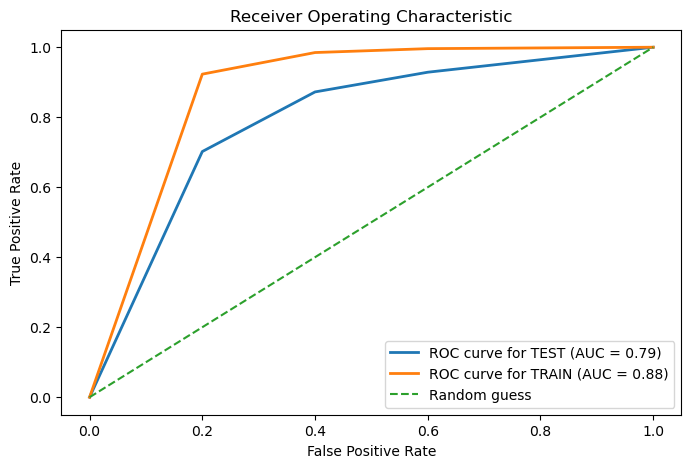

TRAINING classification report: 
               precision    recall  f1-score   support

           0       0.93      0.76      0.84      6747
           1       0.82      0.95      0.88      7891

    accuracy                           0.86     14638
   macro avg       0.88      0.86      0.86     14638
weighted avg       0.87      0.86      0.86     14638


TESTING classification report: 
               precision    recall  f1-score   support

           0       0.89      0.32      0.47      4855
           1       0.52      0.95      0.67      3711

    accuracy                           0.59      8566
   macro avg       0.70      0.63      0.57      8566
weighted avg       0.73      0.59      0.56      8566

Test accuracy: 0.59
>> Test precision: 0.59 <<
Test recall: 0.59
Test F1 score: 0.59
Test AUC score: 0.79


In [197]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Initialize the model with regularization
gbt_clf = GradientBoostingClassifier(learning_rate = 0.003, 
                                     subsample = .05, 
                                     #max_depth=10, 
                                     #min_samples_split=2, 
                                     #min_samples_leaf=1, 
                                     #max_leaf_nodes=None, 
                                     random_state=seed)

# Train the model on the training data
gbt_clf.fit(X_train_scaled, y_train)

ROC(gbt_clf,X_train_scaled, X_test_scaled, y_train, y_test)


<Axes: >

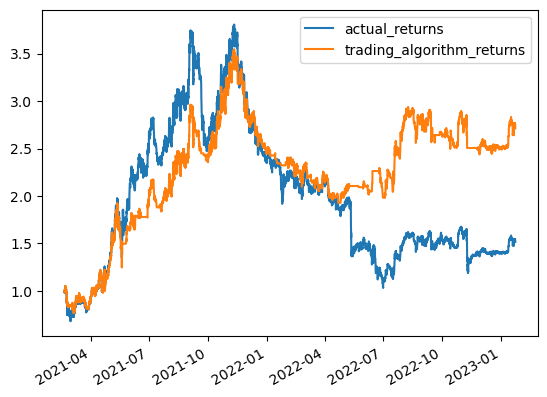

In [198]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = gbt_clf

# Backtest using our exteranl function
gbt_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + gbt_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


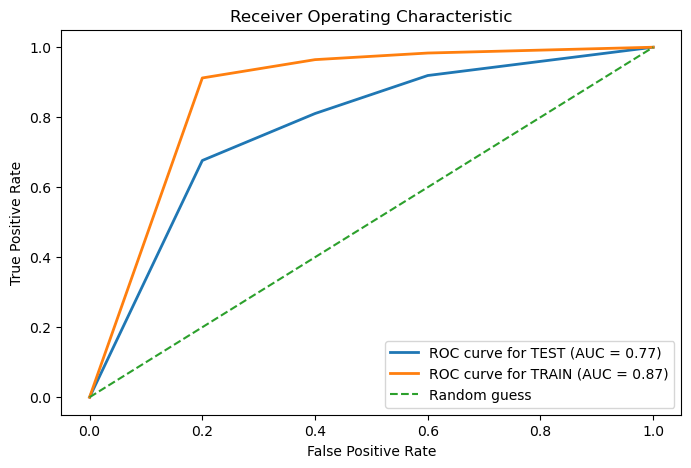

TRAINING classification report: 
               precision    recall  f1-score   support

           0       0.88      0.81      0.84      6747
           1       0.85      0.91      0.87      7891

    accuracy                           0.86     14638
   macro avg       0.86      0.86      0.86     14638
weighted avg       0.86      0.86      0.86     14638


TESTING classification report: 
               precision    recall  f1-score   support

           0       0.86      0.17      0.28      4855
           1       0.47      0.96      0.63      3711

    accuracy                           0.51      8566
   macro avg       0.66      0.57      0.46      8566
weighted avg       0.69      0.51      0.43      8566

Test accuracy: 0.51
>> Test precision: 0.51 <<
Test recall: 0.51
Test F1 score: 0.51
Test AUC score: 0.77


In [199]:
# create the logistic regression model
lr_model = LogisticRegression()

# fit the model on the training data
lr_model.fit(X_train_scaled, y_train)

# display ROC curve and classification results
ROC(lr_model,X_train_scaled,X_test_scaled,y_train,y_test)

<Axes: >

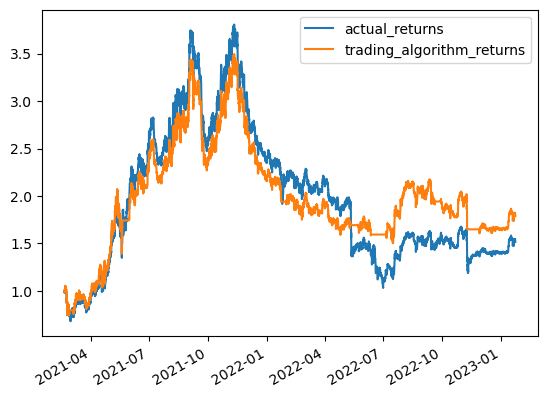

In [201]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = lr_model

# Backtest using our exteranl function
lr_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + lr_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

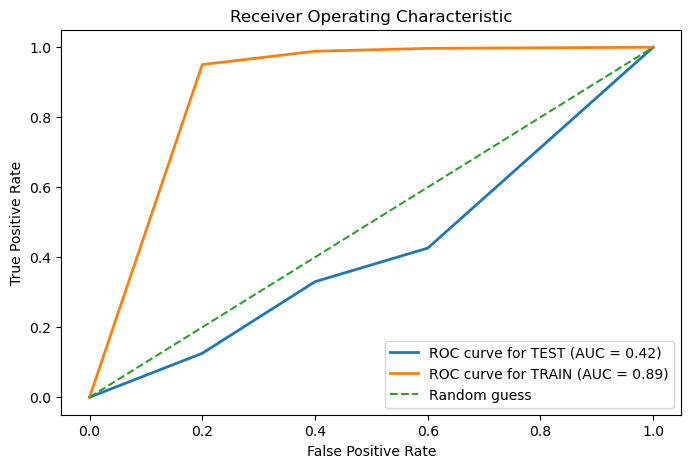

TRAINING classification report: 
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      6747
           1       0.91      0.92      0.91      7891

    accuracy                           0.91     14638
   macro avg       0.91      0.91      0.91     14638
weighted avg       0.91      0.91      0.91     14638


TESTING classification report: 
               precision    recall  f1-score   support

           0       0.52      0.56      0.54      4855
           1       0.37      0.34      0.35      3711

    accuracy                           0.46      8566
   macro avg       0.45      0.45      0.45      8566
weighted avg       0.46      0.46      0.46      8566

Test accuracy: 0.46
>> Test precision: 0.46 <<
Test recall: 0.46
Test F1 score: 0.46
Test AUC score: 0.42


In [200]:
# create the logistic regression model
svm_model = svm.SVC(C=.55, probability=True)

# fit the model on the training data
svm_model.fit(X_train_scaled, y_train)

# display ROC curve and classification results
ROC(svm_model,X_train_scaled,X_test_scaled,y_train,y_test)

<Axes: >

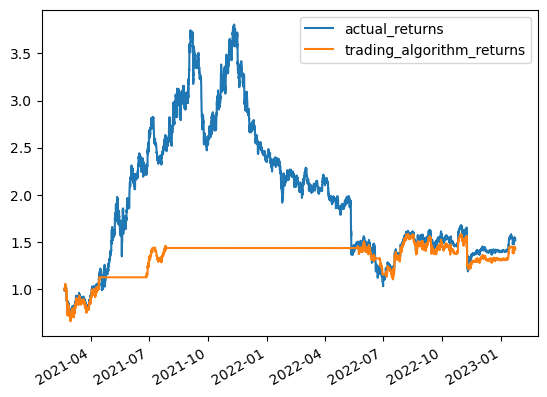

In [110]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = svm_model

# Backtest using our exteranl function
svm_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + svm_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

---
## 4. Using DCA Strategy 

In [202]:
df = gbt_predictions_df
df['close'] = df_eda['close']

# Rename column 'predicted_signal' to 'gbt_prediction'
df = df.rename(columns={'predicted_signal': 'gbt_prediction'})

In [212]:
import pandas as pd
import numpy as np
import hvplot.pandas

# Assuming df is already loaded with 'close' and 'gbt_prediction' columns
initial_capital = 10000
duration_dca_buy = 5
duration_dca_sell = 1

# Add new columns to store calculations
df['eth_owned'] = 0.0
df['current_usd_capital'] = initial_capital
df['algo_value'] = 0.0
df['dca_value'] = 0.0
df['dca_eth_owned'] = 0.0

# Initialize the remaining buy and sell duration
remaining_buy_duration = duration_dca_buy
remaining_sell_duration = 0

# Calculate the daily_buy_amount for DCA strategy
daily_dca_buy_amount = initial_capital / duration_dca_buy

# Loop through each row in the dataset
for i in range(1, len(df)):
    eth_owned = df.loc[df.index[i - 1], 'eth_owned']
    current_usd_capital = df.loc[df.index[i - 1], 'current_usd_capital']
    dca_eth_owned = df.loc[df.index[i - 1], 'dca_eth_owned']
    
    if df.loc[df.index[i], 'gbt_prediction'] == 1:
        if remaining_buy_duration > 0:
            # Calculate the daily_buy_amount based on the remaining buy duration
            daily_buy_amount = current_usd_capital / remaining_buy_duration
            remaining_buy_duration -= 1
        else:
            daily_buy_amount = 0

        # Buy using dollar-cost averaging
        if df.loc[df.index[i], 'close'] > 0:
            eth_to_buy = daily_buy_amount / df.loc[df.index[i], 'close']
            eth_owned += eth_to_buy
            current_usd_capital -= daily_buy_amount
        
            # Update daily_sell_amount
            daily_sell_amount = (eth_owned * df.loc[df.index[i], 'close']) / duration_dca_sell
        
    elif df.loc[df.index[i], 'gbt_prediction'] == 0 and eth_owned > 0:
        # Reset remaining_buy_duration
        remaining_buy_duration = duration_dca_buy
        
        # Sell using dollar-cost averaging
        if df.loc[df.index[i], 'close'] > 0:
            eth_to_sell = daily_sell_amount / df.loc[df.index[i], 'close']
            eth_owned -= eth_to_sell
            current_usd_capital += daily_sell_amount

    df.loc[df.index[i], 'eth_owned'] = eth_owned
    df.loc[df.index[i], 'current_usd_capital'] = current_usd_capital
    df.loc[df.index[i], 'algo_value'] = eth_owned * df.loc[df.index[i], 'close'] + current_usd_capital
    
    # Update DCA value and DCA ETH holdings
    if df.loc[df.index[i], 'close'] > 0:
        if initial_capital > 0:
            dca_eth_to_buy = daily_dca_buy_amount / df.loc[df.index[i], 'close']
            dca_eth_owned += dca_eth_to_buy
            initial_capital -= daily_dca_buy_amount
        else:
            dca_eth_to_buy = 0
            daily_dca_buy_amount = 0

        df.loc[df.index[i], 'dca_eth_owned'] = dca_eth_owned
        df.loc[df.index[i], 'dca_value'] = dca_eth_owned * df.loc[df.index[i], 'close']




In [213]:

# Plot the results
plot = df[['algo_value','dca_value']].hvplot.line(title='Algo-Trading with DCA_Strategy vs. DCA-ETH', width=1000, height=400)
plot


:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [214]:
plot = (1 + gbt_predictions_df[["trading_algorithm_returns", "actual_returns"]]).cumprod().hvplot.line(title='ETH HODL returns vs Algo-Trading w/o DCA',width=1100, height=400)
plot

:NdOverlay   [Variable]
   :Curve   [index]   (value)

---
## 5 Model Building helpers

These utilities below are helpful for identifying the best models and understanding them better. However, they may take a long time to run. If needed, you can interrupt their execution as they are not essential for the machine learning process.

### Selecting best performing model 

In [216]:
model_selection(X_test_scaled,y_test)

,Model Name,F1_Mean,F1_Standard Deviation
0,LinearDiscriminantAnalysis,0.83,0.015
1,KNeighborsClassifier,0.99,0.002
2,DecisionTreeClassifier,0.99,0.003
3,RandomForestClassifier,0.99,0.002
4,ExtraTreesClassifier,0.99,0.003
5,AdaBoostClassifier,0.98,0.004
6,SVM,0.85,0.015
7,GradientBoostingClassifier,0.98,0.005
8,XGBoost,0.99,0.002


### SHAP Analysis 

In [ ]:
# Resample X_test
upscaled_X_test = X_test.resample('1D').interpolate(method='linear')


In [ ]:
# define which classifier to use 
clf = xgb_clf


# Initialize SHAP explainer
explainer = shap.Explainer(clf.predict, upscaled_X_test)

# Calculate SHAP values
shap_values = explainer(upscaled_X_test)

shap.summary_plot(shap_values, upscaled_X_test, plot_type="bar")

In [ ]:
# SHAP Analysis 
# define which classifier to use 
clf = cb_clf

# Initialize SHAP explainer
explainer = shap.Explainer(clf.predict, upscaled_X_test)

# Calculate SHAP values
shap_values = explainer(upscaled_X_test)

shap.summary_plot(shap_values, upscaled_X_test, plot_type="bar")